In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
from wordcloud import WordCloud
import re
from collections import Counter
from gensim import corpora
from gensim.models import LdaModel

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Keaton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Keaton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Keaton\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Keaton\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# Load data
df = pd.read_csv('IMDB_Dataset.csv') 
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


1- Data Exploration: Compute basic statistics (mean, median, min, max) for the length of the reviews (measured by the
number of words and characters). Visualize the distribution of review lengths using histograms or box plots. Compare the
length of reviews for positive and negative sentiments.

In [4]:
# Add review length columns
df['word_count'] = df['review'].apply(lambda x: len(x.split()))
df['char_count'] = df['review'].apply(lambda x: len(x))

# Calculate basic statistics
print("Word Count Stats:")
print(df['word_count'].describe())
print("\nCharacter Count Stats:")
print(df['char_count'].describe())

Word Count Stats:
count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: word_count, dtype: float64

Character Count Stats:
count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: char_count, dtype: float64


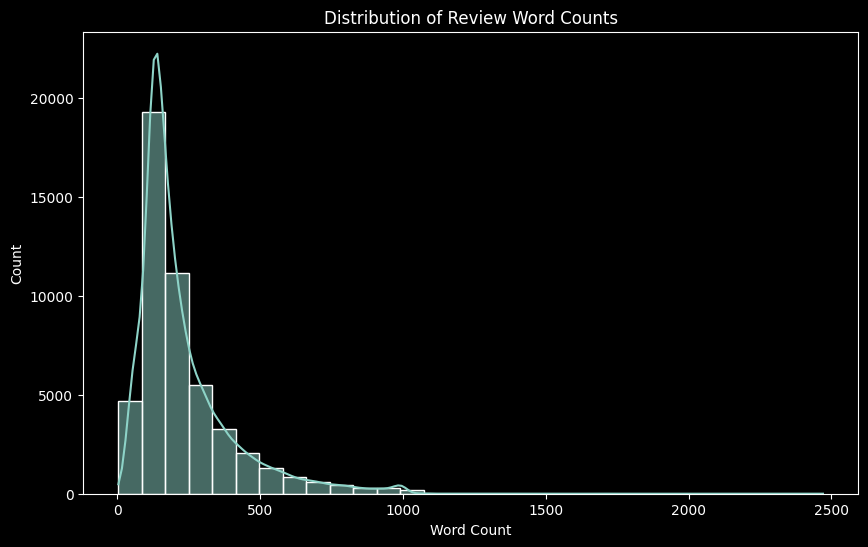

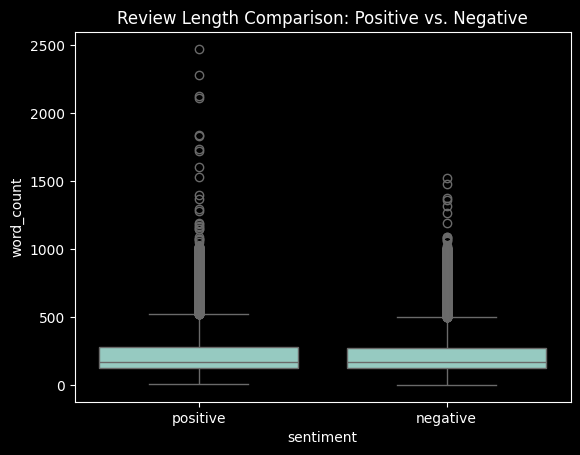

In [5]:
# Histograms for word count
plt.figure(figsize=(10,6))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title('Distribution of Review Word Counts')
plt.xlabel('Word Count')
plt.show()

# Box plot comparison for positive vs. negative reviews
sns.boxplot(x='sentiment', y='word_count', data=df)
plt.title('Review Length Comparison: Positive vs. Negative')
plt.show();

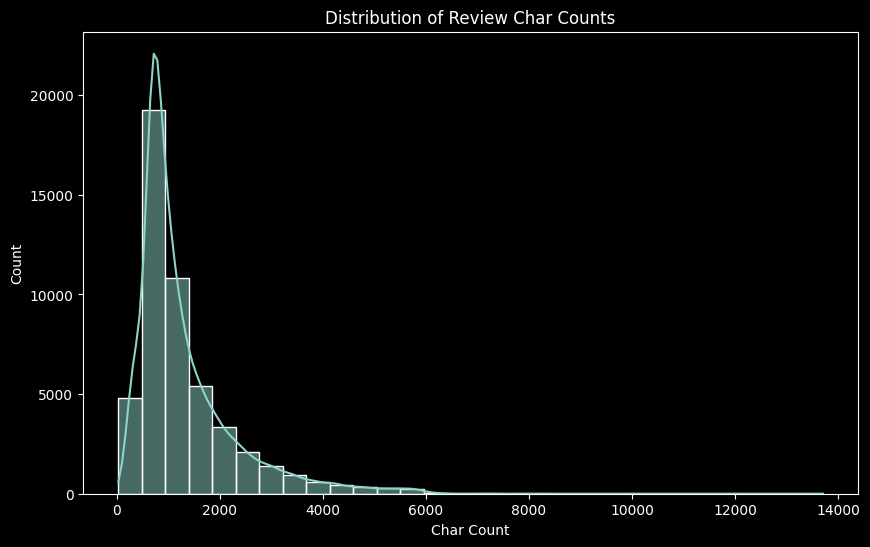

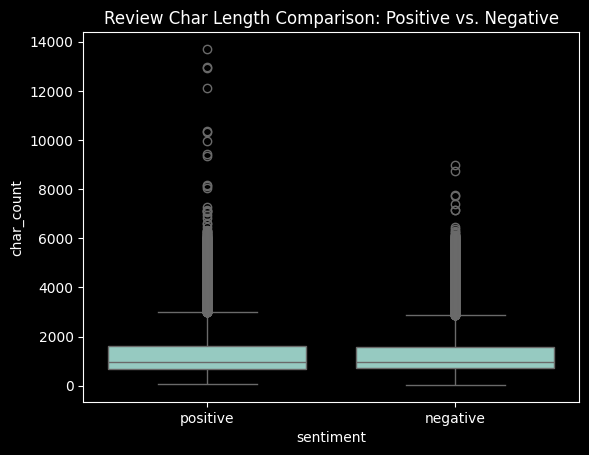

In [7]:
# Histograms for char count
plt.figure(figsize=(10,6))
sns.histplot(df['char_count'], bins=30, kde=True)
plt.title('Distribution of Review Char Counts')
plt.xlabel('Char Count')
plt.show()

# Box plot comparison for positive vs. negative reviews
sns.boxplot(x='sentiment', y='char_count', data=df)
plt.title('Review Char Length Comparison: Positive vs. Negative')
plt.show();

2- Data Cleaning: Perform standard text preprocessing tasks, including: Removing stop words, punctuation, and special
characters, Lowercasing the text, Tokenizing the reviews, Stemming or lemmatization.

In [18]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Remove URLs
    text = re.sub(r'http\S+', ' ', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove special characters and digits
    text = re.sub(r'\W|\d', ' ', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and stemming
    tokens = [ps.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
df['cleaned_review'] = df['review'].apply(preprocess_text)

3- Review Word Frequency Analysis: 1- Most Common Words: Generate a word frequency count for both the positive and
negative reviews. Visualize the most frequent words using word clouds and bar charts, with separate visualizations for positive
and negative reviews. and 2- N-gram Analysis: Explore bi-grams and tri-grams (two- and three-word combinations) to
uncover common phrases in the reviews. Separate this analysis for positive and negative reviews to observe any recurring
phrases that indicate strong sentiment.

In [19]:
df['word_count'] = df['cleaned_review'].apply(lambda x: len(x.split()))
df['char_count'] = df['cleaned_review'].apply(lambda x: len(x))

In [20]:
df['cleaned_review']

0        one review mention watch oz episod youll hook ...
1        wonder littl product film techniqu unassum old...
2        thought wonder way spend time hot summer weeke...
3        basic there famili littl boy jake think there ...
4        petter mattei love time money visual stun film...
                               ...                        
49995    thought movi right good job wasnt creativ orig...
49996    bad plot bad dialogu bad act idiot direct anno...
49997    cathol taught parochi elementari school nun ta...
49998    im go disagre previou comment side maltin one ...
49999    one expect star trek movi high art fan expect ...
Name: cleaned_review, Length: 50000, dtype: object

In [21]:
# Separate positive and negative reviews
positive_reviews = df[df['sentiment'] == 'positive']['cleaned_review']
negative_reviews = df[df['sentiment'] == 'negative']['cleaned_review']

In [22]:
# Function to get word frequency
def get_word_frequencies(text):
    words = ' '.join(text).split()
    word_count = Counter(words)
    return word_count

# Get word frequencies for positive and negative reviews
positive_word_freq = get_word_frequencies(positive_reviews)
negative_word_freq = get_word_frequencies(negative_reviews)

# Convert to DataFrame for easier viewing and sorting
positive_word_freq_df = pd.DataFrame(positive_word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
negative_word_freq_df = pd.DataFrame(negative_word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Display top 10 most common words for each
print("Top 10 words in Positive Reviews:")
print(positive_word_freq_df.head(10))

print("\nTop 10 words in Negative Reviews:")
print(negative_word_freq_df.head(10))

Top 10 words in Positive Reviews:
        Word  Frequency
140     film      49920
277     movi      43931
0        one      27540
373     like      20021
202     time      15929
161      see      14839
325     good      14800
349    stori      13917
215  charact      13830
339     make      13213

Top 10 words in Negative Reviews:
      Word  Frequency
12    movi      57041
26    film      44038
98     one      26281
33    like      24060
25    make      15459
264   even      15284
372    get      15195
43   watch      14844
11    time      14776
357   good      14542


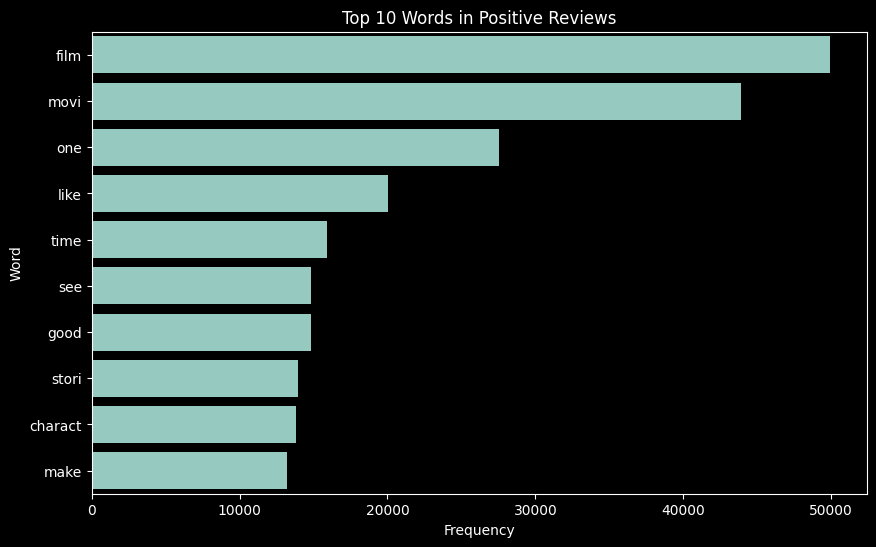

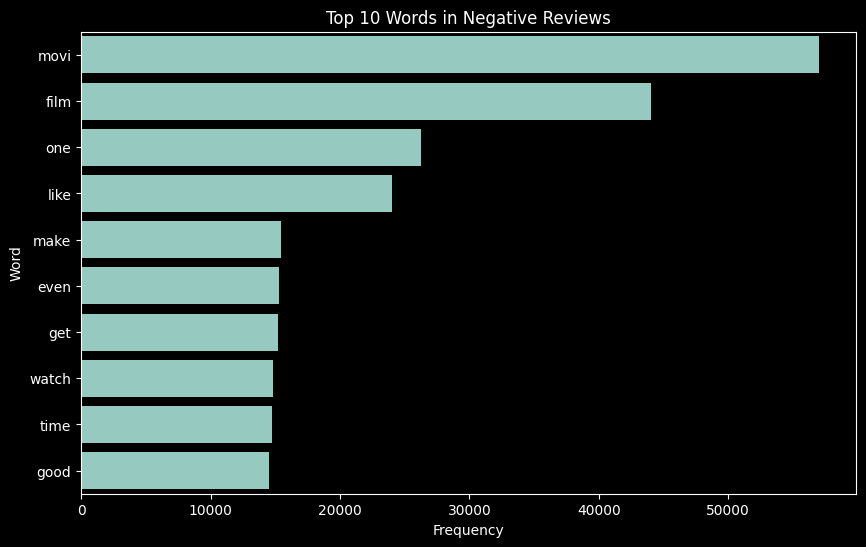

In [23]:
# Function to plot top words
def plot_top_words(word_freq_df, title):
    top_words = word_freq_df.head(10)
    plt.figure(figsize=(10,6))
    sns.barplot(x='Frequency', y='Word', data=top_words)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()

# Plot top words for positive and negative reviews
plot_top_words(positive_word_freq_df, 'Top 10 Words in Positive Reviews')
plot_top_words(negative_word_freq_df, 'Top 10 Words in Negative Reviews')

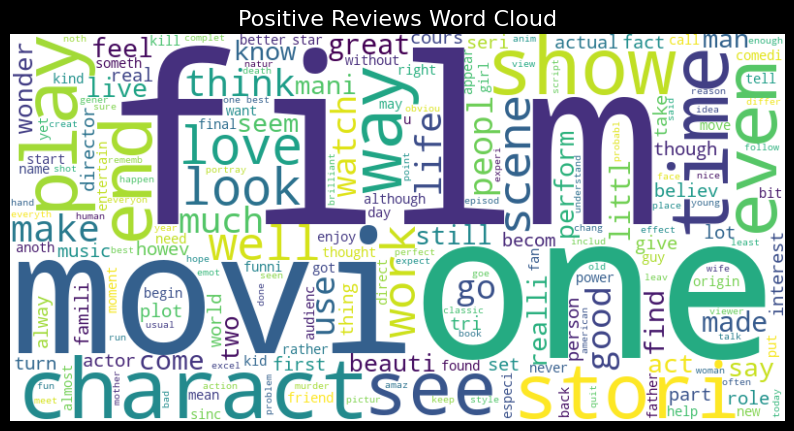

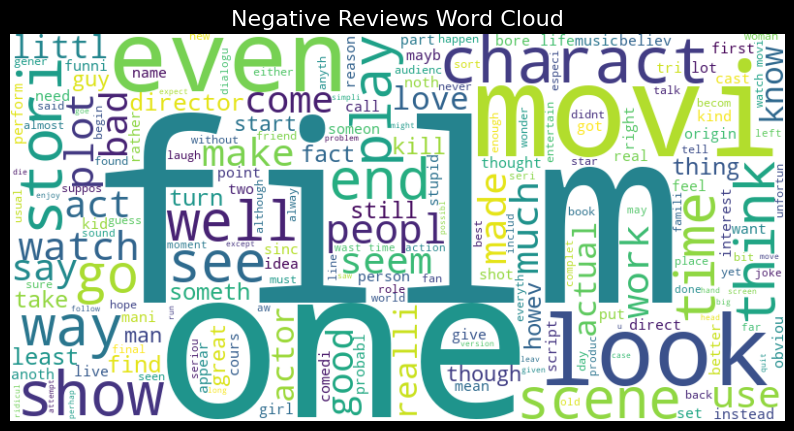

In [27]:
# Generate word cloud
def generate_wordcloud(text, caption):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(caption, fontsize=16) 
    plt.show()

generate_wordcloud(positive_reviews, "Positive Reviews Word Cloud")
generate_wordcloud(negative_reviews, "Negative Reviews Word Cloud")

In [25]:
# Function to get n-grams
def get_top_ngrams(corpus, n=2, top_n=10):
    """
    Generate the most common n-grams from a list of documents.
    
    :param corpus: List of documents (text reviews)
    :param n: The number of words in the n-gram (2 for bi-grams, 3 for tri-grams)
    :param top_n: The number of top n-grams to return
    :return: DataFrame of the top n-grams and their frequencies
    """
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    ngram_freq = vec.transform(corpus)
    sum_ngrams = ngram_freq.sum(axis=0)
    
    # Get n-grams and their frequencies
    ngrams = [(ngram, sum_ngrams[0, idx]) for ngram, idx in vec.vocabulary_.items()]
    ngrams = sorted(ngrams, key=lambda x: x[1], reverse=True)[:top_n]
    
    # Convert to DataFrame for easier viewing
    ngram_df = pd.DataFrame(ngrams, columns=['N-gram', 'Frequency'])
    return ngram_df

# Example usage:
positive_bigrams = get_top_ngrams(positive_reviews, n=2, top_n=10)
negative_bigrams = get_top_ngrams(negative_reviews, n=2, top_n=10)

positive_trigrams = get_top_ngrams(positive_reviews, n=3, top_n=10)
negative_trigrams = get_top_ngrams(negative_reviews, n=3, top_n=10)


In [28]:
# Display results
print("Top 10 Bi-grams in Positive Reviews:")
print(positive_bigrams)

print("\nTop 10 Bi-grams in Negative Reviews:")
print(negative_bigrams)

Top 10 Bi-grams in Positive Reviews:
             N-gram  Frequency
0          ive seen       1538
1        watch movi       1316
2         look like        966
3         dont know        898
4         movi like        886
5  highli recommend        879
6          new york        842
7      main charact        835
8          year old        825
9        watch film        813

Top 10 Bi-grams in Negative Reviews:
           N-gram  Frequency
0       look like       2791
1        ive seen       1891
2      watch movi       1836
3       wast time       1690
4  special effect       1438
5       dont know       1306
6        bad movi       1240
7       movi like       1180
8      worst movi       1148
9       make movi       1087


In [29]:
print("\nTop 10 Tri-grams in Positive Reviews:")
print(positive_trigrams)

print("\nTop 10 Tri-grams in Negative Reviews:")
print(negative_trigrams)


Top 10 Tri-grams in Positive Reviews:
                  N-gram  Frequency
0          film ive seen        235
1          movi ive seen        221
2          new york citi        193
3           world war ii        157
4        base true stori        139
5          ive seen movi         92
6         seen long time         91
7  highli recommend movi         88
8     intern film festiv         82
9  highli recommend film         72

Top 10 Tri-grams in Negative Reviews:
              N-gram  Frequency
0      movi ive seen        420
1     dont wast time        371
2    worst movi seen        322
3     worst movi ive        236
4      film ive seen        217
5    wast time money        205
6    worst film seen        150
7   doesnt make sens        131
8  complet wast time        127
9        bad act bad        126


4- Correlation Between Review Length and Sentiment: Calculate the correlation between sentiment and review length and
analyze whether longer or shorter reviews tend to be positive or negative. Plot the average review length for positive and
negative reviews to explore potential patterns.

In [30]:
# Convert sentiment to numeric values: 1 for positive, 0 for negative
df['sentiment_numeric'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Calculate the correlation between sentiment and review length (word count)
correlation = df['sentiment_numeric'].corr(df['word_count'])
print(f"Correlation between sentiment and review length: {correlation:.2f}")

Correlation between sentiment and review length: 0.02


In [31]:
# Calculate average review length for positive and negative reviews
average_length_positive = df[df['sentiment'] == 'positive']['word_count'].mean()
average_length_negative = df[df['sentiment'] == 'negative']['word_count'].mean()

print(f"Average Review Length (Positive): {average_length_positive:.2f} words")
print(f"Average Review Length (Negative): {average_length_negative:.2f} words")

Average Review Length (Positive): 120.34 words
Average Review Length (Negative): 117.61 words


C:\Users\Keaton\AppData\Local\Temp\ipykernel_13924\1903757467.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Average Word Count', data=avg_length_df, palette='viridis')


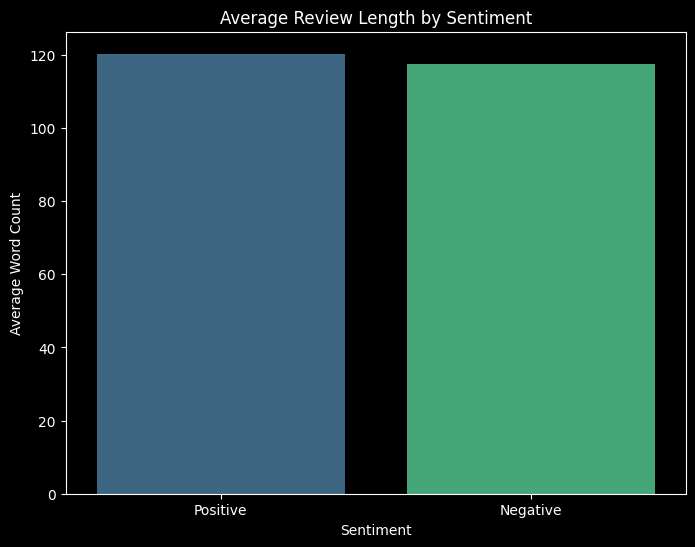

In [32]:
# Create a DataFrame for visualization
avg_length_df = pd.DataFrame({
    'Sentiment': ['Positive', 'Negative'],
    'Average Word Count': [average_length_positive, average_length_negative]
})

# Plot the average review length
plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Average Word Count', data=avg_length_df, palette='viridis')
plt.title('Average Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Word Count')
plt.show()

5- Review Complexity Analysis: Calculate readability metrics such as the Flesch-Kincaid or Gunning Fog Index for each
review to assess its complexity. This analysis explores whether there is a correlation between the complexity of the review
and its sentiment (e.g., do more complex reviews tend to be positive or negative?). Also, lexical diversity, which is the ratio
of unique words to total words, will be measured for each review. The lexical diversity of positive and negative reviews will
then be compared to identify any differences in language richness between the two sentiment classes.

In [37]:
import textstat

# Function to calculate Flesch-Kincaid Grade Level and Gunning Fog Index
def calculate_readability_metrics(text):
    fk_grade = textstat.flesch_kincaid_grade(text)
    fog_index = textstat.gunning_fog(text)
    return fk_grade, fog_index

# Apply functions to each review
df['flesch_kincaid_grade'], df['gunning_fog_index'] = zip(*df['cleaned_review'].apply(calculate_readability_metrics))

# Show a sample of the DataFrame
df[['cleaned_review', 'flesch_kincaid_grade', 'gunning_fog_index', 'sentiment']].head()

,cleaned_review,flesch_kincaid_grade,gunning_fog_index,sentiment
0,one review mention watch oz episod youll hook ...,66.9,69.05,positive
1,wonder littl product film techniqu unassum old...,38.4,37.89,positive
2,thought wonder way spend time hot summer weeke...,36.4,38.24,positive
3,basic there famili littl boy jake think there ...,28.2,29.19,negative
4,petter mattei love time money visual stun film...,50.9,51.92,positive


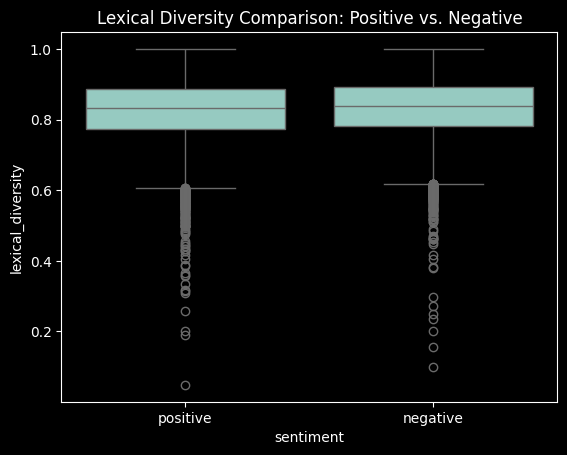

In [38]:
def lexical_diversity(text):
    words = text.split()
    return len(set(words)) / len(words)

df['lexical_diversity'] = df['cleaned_review'].apply(lexical_diversity)

# Compare between positive and negative
sns.boxplot(x='sentiment', y='lexical_diversity', data=df)
plt.title('Lexical Diversity Comparison: Positive vs. Negative')
plt.show()

In [39]:
# Calculate correlations
fk_correlation = df['flesch_kincaid_grade'].corr(df['sentiment_numeric'])
fog_correlation = df['gunning_fog_index'].corr(df['sentiment_numeric'])
lexical_diversity_correlation = df['lexical_diversity'].corr(df['sentiment_numeric'])

print(f"Correlation between Flesch-Kincaid Grade Level and Sentiment: {fk_correlation:.2f}")
print(f"Correlation between Gunning Fog Index and Sentiment: {fog_correlation:.2f}")
print(f"Correlation between Lexical Diversity and Sentiment: {lexical_diversity_correlation:.2f}")

Correlation between Flesch-Kincaid Grade Level and Sentiment: 0.02
Correlation between Gunning Fog Index and Sentiment: 0.01
Correlation between Lexical Diversity and Sentiment: -0.03


Average Lexical Diversity (Positive): 0.83
Average Lexical Diversity (Negative): 0.83


C:\Users\Keaton\AppData\Local\Temp\ipykernel_13924\2719445389.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Average Lexical Diversity', data=avg_lexical_diversity_df, palette='viridis')


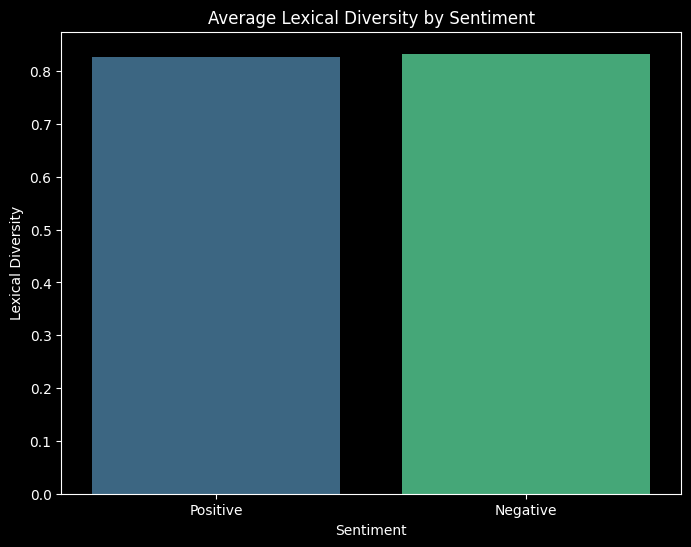

In [40]:
# Calculate average lexical diversity for positive and negative reviews
avg_lexical_diversity_positive = df[df['sentiment'] == 'positive']['lexical_diversity'].mean()
avg_lexical_diversity_negative = df[df['sentiment'] == 'negative']['lexical_diversity'].mean()

print(f"Average Lexical Diversity (Positive): {avg_lexical_diversity_positive:.2f}")
print(f"Average Lexical Diversity (Negative): {avg_lexical_diversity_negative:.2f}")

# Visualize lexical diversity comparison
avg_lexical_diversity_df = pd.DataFrame({
    'Sentiment': ['Positive', 'Negative'],
    'Average Lexical Diversity': [avg_lexical_diversity_positive, avg_lexical_diversity_negative]
})

plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Average Lexical Diversity', data=avg_lexical_diversity_df, palette='viridis')
plt.title('Average Lexical Diversity by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Lexical Diversity')
plt.show()

6- Part-of-Speech (POS) Tagging Analysis: Apply POS tagging to the text data to categorize words into grammatical
categories such as nouns, verbs, adjectives, etc. The aim is to explore the frequency and distribution of various parts of speech
in both positive and negative reviews. For instance, investigate whether adjectives and adverbs, which often convey sentiment,
occur more frequently in positive reviews compared to negative ones.

In [42]:
#FTH

# Function to perform POS tagging and count frequencies of POS categories
def pos_tag_analysis(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Perform POS tagging
    pos_tags = nltk.pos_tag(tokens)
    # Count POS categories
    pos_counts = {
        'nouns': 0,
        'verbs': 0,
        'adjectives': 0,
        'adverbs': 0
    }
    for word, tag in pos_tags:
        if tag.startswith('NN'):  # Noun
            pos_counts['nouns'] += 1
        elif tag.startswith('VB'):  # Verb
            pos_counts['verbs'] += 1
        elif tag.startswith('JJ'):  # Adjective
            pos_counts['adjectives'] += 1
        elif tag.startswith('RB'):  # Adverb
            pos_counts['adverbs'] += 1
    
    return pos_counts

# Only remove unwanted HTML tags and URLs, do not lowercase or tokenize
def preprocess_text_for_pos(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Remove URLs
    text = re.sub(r'http\S+', ' ', text)
    # Remove extra whitespace, preserve punctuation
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply POS-specific preprocessing
df['preprocessed_review'] = df['review'].apply(preprocess_text_for_pos)


# Apply the function to each review and store results in new columns
df[['nouns', 'verbs', 'adjectives', 'adverbs']] = df['preprocessed_review'].apply(lambda x: pd.Series(pos_tag_analysis(x)))

# Show a sample of the DataFrame
df[['preprocessed_review', 'nouns', 'verbs', 'adjectives', 'adverbs', 'sentiment']].head()

,preprocessed_review,nouns,verbs,adjectives,adverbs,sentiment
0,One of the other reviewers has mentioned that ...,90,54,32,21,positive
1,A wonderful little production. The filming tec...,39,24,14,19,positive
2,I thought this was a wonderful way to spend ti...,39,34,15,10,positive
3,Basically there's a family where a little boy ...,34,26,7,6,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",74,31,25,4,positive


In [43]:
# Calculate average counts of POS categories for positive and negative reviews
avg_pos_positive = df[df['sentiment'] == 'positive'][['nouns', 'verbs', 'adjectives', 'adverbs']].mean()
avg_pos_negative = df[df['sentiment'] == 'negative'][['nouns', 'verbs', 'adjectives', 'adverbs']].mean()

# Combine into a DataFrame for easier comparison
avg_pos_df = pd.DataFrame({
    'POS': ['Nouns', 'Verbs', 'Adjectives', 'Adverbs'],
    'Positive': avg_pos_positive.values,
    'Negative': avg_pos_negative.values
})

print(avg_pos_df)

          POS  Positive  Negative
0       Nouns  62.35784  58.06072
1       Verbs  38.91924  41.17064
2  Adjectives  20.55996  19.89908
3     Adverbs  15.35448  16.57576


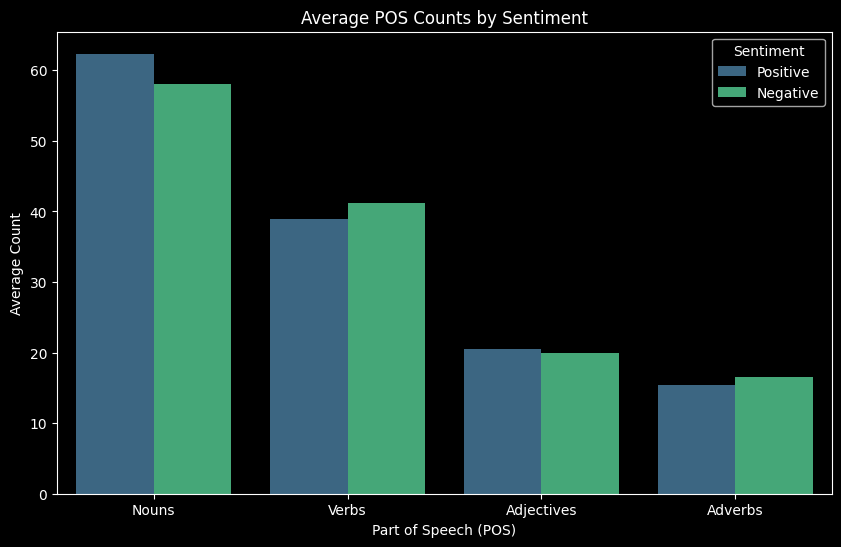

In [44]:
# Melt DataFrame for plotting
avg_pos_melted = avg_pos_df.melt(id_vars='POS', value_vars=['Positive', 'Negative'], var_name='Sentiment', value_name='Average Count')

# Plot the average POS counts
plt.figure(figsize=(10, 6))
sns.barplot(x='POS', y='Average Count', hue='Sentiment', data=avg_pos_melted, palette='viridis')
plt.title('Average POS Counts by Sentiment')
plt.xlabel('Part of Speech (POS)')
plt.ylabel('Average Count')
plt.show()

7- Sentiment Analysis on Review Topics: Using topic modeling techniques such as Latent Dirichlet Allocation (LDA),
identify the main topics in the reviews. After identifying these topics, analyze the sentiment of the reviews within each topic
to determine if specific topics tend to evoke more positive or negative sentiment.

In [ ]:
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Apply preprocessing to all reviews
df['tokens'] = df['cleaned_review'].apply(tokenize_text)

In [ ]:
# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

In [ ]:
# Set number of topics
num_topics = 5

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")

In [ ]:
# Function to get the dominant topic for each review
def get_dominant_topic(lda_model, bow):
    topics = lda_model[bow]
    dominant_topic = max(topics, key=lambda x: x[1])[0]
    return dominant_topic

# Apply the function to get the dominant topic for each review
df['dominant_topic'] = [get_dominant_topic(lda_model, bow) for bow in corpus]

In [ ]:
# Group by topic and sentiment to see distribution
topic_sentiment_distribution = df.groupby(['dominant_topic', 'sentiment']).size().unstack().fillna(0)
topic_sentiment_distribution['Total'] = topic_sentiment_distribution.sum(axis=1)

# Calculate percentage of positive and negative reviews for each topic
topic_sentiment_distribution['Positive %'] = (topic_sentiment_distribution['positive'] / topic_sentiment_distribution['Total']) * 100
topic_sentiment_distribution['Negative %'] = (topic_sentiment_distribution['negative'] / topic_sentiment_distribution['Total']) * 100

print(topic_sentiment_distribution[['Positive %', 'Negative %']])

In [ ]:
# Visualize sentiment distribution for each topic
topic_sentiment_distribution[['Positive %', 'Negative %']].plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Sentiment Distribution Across Topics')
plt.xlabel('Topic')
plt.ylabel('Percentage')
plt.legend(loc='upper right')
plt.show()

8- Comparison of Pre-Trained Sentiment Models with Ground Truth Labels: Use pre-trained models like VADER and
TextBlob to analyze the sentiment of the reviews, assigning a sentiment polarity score (positive, and negative) to each review.
To compare these sentiment scores with the ground truth labels (positive or negative) in the dataset, create a confusion matrix
to assess how well the pre-trained models align with the true labels. Calculate evaluation metrics such as accuracy, precision,
recall, and F1-score for both VADER and TextBlob. Additionally, visualize the distribution of sentiment polarity scores
generated by these models for both the positive and negative labeled reviews to identify any discrepancies between the model
predictions and the actual labels. Use bar plots or stacked bar plots to show the agreement or disagreement between the pre-
trained models’ polarity scores and the true sentiment labels. Also, conduct an error analysis to inspect cases where the pre-
trained models significantly differ from the ground truth (e.g., reviews labeled as positive but classified as negative by
VADER), and discuss patterns or common characteristics of reviews where these models perform poorly, such as sarcasm or
ambiguous language.

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize VADER Sentiment Analyzer
vader_analyzer = SentimentIntensityAnalyzer()

In [ ]:
# Function to classify sentiment using VADER
def vader_sentiment(review):
    score = vader_analyzer.polarity_scores(review)['compound']
    return 'positive' if score >= 0 else 'negative'

# Apply VADER to classify reviews
df['vader_sentiment'] = df['cleaned_review'].apply(vader_sentiment)

In [ ]:
# Function to classify sentiment using TextBlob
def textblob_sentiment(review):
    score = TextBlob(review).sentiment.polarity
    return 'positive' if score >= 0 else 'negative'

# Apply TextBlob to classify reviews
df['textblob_sentiment'] = df['cleaned_review'].apply(textblob_sentiment)

In [ ]:
# Function to print evaluation metrics
def evaluate_model(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, pos_label='positive')
    recall = recall_score(true_labels, predicted_labels, pos_label='positive')
    f1 = f1_score(true_labels, predicted_labels, pos_label='positive')
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

# Evaluate VADER
print("VADER Evaluation:")
evaluate_model(df['sentiment'], df['vader_sentiment'])

# Confusion matrix for VADER
vader_cm = confusion_matrix(df['sentiment'], df['vader_sentiment'], labels=['positive', 'negative'])
sns.heatmap(vader_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
plt.title("VADER Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Evaluate TextBlob
print("TextBlob Evaluation:")
evaluate_model(df['sentiment'], df['textblob_sentiment'])

# Confusion matrix for TextBlob
textblob_cm = confusion_matrix(df['sentiment'], df['textblob_sentiment'], labels=['positive', 'negative'])
sns.heatmap(textblob_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
plt.title("TextBlob Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Function to get VADER polarity scores
df['vader_polarity'] = df['cleaned_review'].apply(lambda x: vader_analyzer.polarity_scores(x)['compound'])
df['textblob_polarity'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Visualize polarity score distributions
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='vader_polarity', hue='sentiment', kde=True, palette='Set1', bins=30)
plt.title('Distribution of VADER Polarity Scores')
plt.xlabel('VADER Polarity Score')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='textblob_polarity', hue='sentiment', kde=True, palette='Set2', bins=30)
plt.title('Distribution of TextBlob Polarity Scores')
plt.xlabel('TextBlob Polarity Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Extract misclassified reviews by VADER
vader_misclassified = df[(df['sentiment'] != df['vader_sentiment'])]
print("Examples of Misclassified Reviews by VADER:")
print(vader_misclassified[['review', 'sentiment', 'vader_sentiment']].head())

# Extract misclassified reviews by TextBlob
textblob_misclassified = df[(df['sentiment'] != df['textblob_sentiment'])]
print("Examples of Misclassified Reviews by TextBlob:")
print(textblob_misclassified[['review', 'sentiment', 'textblob_sentiment']].head())

# Analyze common patterns
vader_negative_as_positive = vader_misclassified[(vader_misclassified['sentiment'] == 'negative') & (vader_misclassified['vader_sentiment'] == 'positive')]
vader_positive_as_negative = vader_misclassified[(vader_misclassified['sentiment'] == 'positive') & (vader_misclassified['vader_sentiment'] == 'negative')]

# Count and analyze patterns
print(f"VADER Negative as Positive: {len(vader_negative_as_positive)}")
print(f"VADER Positive as Negative: {len(vader_positive_as_negative)}")

9- Feature Extraction for Sentiment Classification: Convert the text reviews into numerical representations suitable for
machine learning models. First, apply the Bag of Words (BoW) method, which represents the text based on word frequency
without considering word order. Next, implement TF-IDF to assign higher importance to less frequent but more meaningful words in the reviews. Finally, explore word embeddings such as Word2Vec, GloVe, or BERT to capture more advanced and
contextual word representations, providing richer semantic information for the sentiment classification models.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

In [ ]:
# Create Bag of Words (BoW) model
vectorizer_bow = CountVectorizer(max_features=5000)  # Limit to 5000 most frequent words
X_bow = vectorizer_bow.fit_transform(df['cleaned_review']).toarray()

# Check BoW features
print("BoW Feature Shape:", X_bow.shape)

In [ ]:
# Create TF-IDF model
vectorizer_tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer_tfidf.fit_transform(df['cleaned_review']).toarray()

# Check TF-IDF features
print("TF-IDF Feature Shape:", X_tfidf.shape)

In [ ]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=5, workers=4)
X_word2vec = np.array([np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for words in df['tokens']])

# Check Word2Vec features
print("Word2Vec Feature Shape:", X_word2vec.shape)

In [ ]:
import gensim.downloader as api

# Load pre-trained GloVe embeddings
glove_model = api.load("glove-wiki-gigaword-100")  # 100-dimensional embeddings

# Convert reviews to GloVe vectors
def get_glove_embeddings(review):
    words = review.split()
    return np.mean([glove_model[word] for word in words if word in glove_model] or [np.zeros(100)], axis=0)

X_glove = np.array([get_glove_embeddings(review) for review in df['cleaned_review']])

# Check GloVe features
print("GloVe Feature Shape:", X_glove.shape)

In [ ]:
# Initialize BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embeddings(review):
    inputs = bert_tokenizer(review, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Convert reviews to BERT embeddings
X_bert = np.array([get_bert_embeddings(review)[0] for review in df['cleaned_review']])

# Check BERT features
print("BERT Feature Shape:", X_bert.shape)

10- Sentiment Prediction Using Extracted Features: Build a sentiment classification model using the features extracted in
Task 13. Train the model on the training dataset using features extracted via Bag of Words (BoW), TF-IDF, and word
embeddings such as Word2Vec, GloVe, or BERT. After training, evaluate the performance of the model on the test dataset.
The goal is to predict whether a review is positive or negative based on these numerical representations. You are required to
compare the performance of various classifiers, including Logistic Regression, Support Vector Machines (SVM), Random
Forest, and Deep Learning models (LSTM or CNN). Each classifier will be applied to BoW, TF-IDF and word embeddings,
and the results should be evaluated using metrics such as accuracy, precision, recall, and F1-score.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['sentiment'], test_size=0.2, random_state=42)

# Train a Logistic Regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

evaluate_model(y_test, clf.predict(X_test))

In [ ]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_bow, df['sentiment'], test_size=0.2, random_state=42)

# Train a Logistic Regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

evaluate_model(y_test, clf.predict(X_test))

In [ ]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_word2vec, df['sentiment'], test_size=0.2, random_state=42)

# Train a Logistic Regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

evaluate_model(y_test, clf.predict(X_test))

In [ ]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_glove, df['sentiment'], test_size=0.2, random_state=42)

# Train a Logistic Regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

evaluate_model(y_test, clf.predict(X_test))

In [ ]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_bert, df['sentiment'], test_size=0.2, random_state=42)

# Train a Logistic Regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

evaluate_model(y_test, clf.predict(X_test))